In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.transforms import Bbox

import dit
from embo import EmpiricalBottleneck
from dit.rate_distortion import IBCurve


plt.style.use('style.mplstyle')

The generalized IB codebase was largely underdocumented, all contained in a single Python file about 1400 lines long (by comparison, the two files that make up the core of embo, excluding tests and packaging files, sum up to less than 400 lines, and that's including a copyright notice in each file). There was no obvious way of running the algorithm for a probability distribution rather than an empirical sample. There were two examples but no indications of what they were supposed to be examples of. I tried running one: it took a very long time to run (on the order of an hour) and at the end I got a printout of some very large pandas dataframes, which I am unsure how to interpret. I gave up.

In [2]:
# set up the same probability distribution in two different formats, one fit-friendly, the other embo-friendly
d_dit = dit.Distribution(['00', '02', '12', '21', '22'], [1/5]*5)
d_embo = np.array([[0.2, 0, 0.2],[0, 0, 0.2], [0, 0.2, 0.2]])

# set up common configurations for the algorithms
numbeta = 71
maxbeta = 5

In [3]:
%%time
# Run bottleneck with Embo
eb = EmpiricalBottleneck(pxy=d_embo, numbeta=numbeta, maxbeta=maxbeta, processes=1)
i_x, i_y, beta, mixy, hx, hy = eb.get_empirical_bottleneck(return_entropies=True)

CPU times: user 121 ms, sys: 32.6 ms, total: 154 ms
Wall time: 363 ms


In [4]:
%%time
# Run bottleneck with dit using scipy.optimize
dit_ib_sp = IBCurve(d_dit, method='sp', beta_num=numbeta, beta_max=maxbeta)

CPU times: user 17.8 s, sys: 77.8 ms, total: 17.9 s
Wall time: 17.7 s


In [5]:
%%time
# run bottleneck with dit using Blahut-Arimoto algorithm (same we use in embo; the original approach)
dit_ib_ba = IBCurve(d_dit, method='ba', beta_num=numbeta, beta_max=maxbeta)

CPU times: user 8min 13s, sys: 2.38 s, total: 8min 15s
Wall time: 8min 11s


In [6]:
# package extracted data for uniform access
results = {
    'embo' : {
        'ix' : i_x,
        'iy' : i_y,
        'beta' : beta,
        'ixy' : mixy,
        'hx' : hx,
    },
    'dit/sp' : {
        'ix' : dit_ib_sp.complexities,
        'iy' : dit_ib_sp.relevances,
        'beta' : dit_ib_sp.betas,
        'ixy' : dit_ib_sp._max_relevance,
        'hx' : dit_ib_sp._max_complexity,
    },
    'dit/ba' : {
        'ix' : dit_ib_ba.complexities,
        'iy' : dit_ib_ba.relevances,
        'beta' : dit_ib_ba.betas,
        'ixy' : dit_ib_ba._max_relevance,
        'hx' : dit_ib_ba._max_complexity,
    }  
}

In [7]:
palette = [item['color'] for item in plt.rcParams['axes.prop_cycle']]

colors = {
    'embo' : palette[2],
    'dit/sp' : palette[1],
    'dit/ba' : palette[3]
}

tool_names = list(colors.keys())

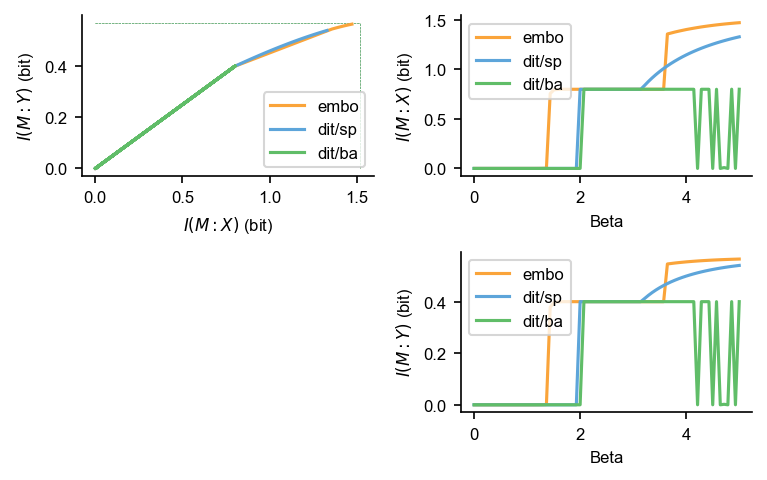

In [8]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=np.array((2,2))*plt.rcParams['figure.figsize'], constrained_layout=True)
legend_loc = 'upper left'

for tool in tool_names:
    res = results[tool]
    color = colors[tool]
    a = ax[0,0]
    a.plot(res['ix'], res['iy'], label=tool, color=color)
    a.legend(loc='lower right')
    a.set_ylabel("$I(M:Y)$ (bit)")
    a.set_xlabel("$I(M:X)$ (bit)")
    a.hlines(res['ixy'], 0, res['hx'], linestyle='--', linewidth=0.3, color=color, zorder=-5)
    a.vlines(res['hx'], 0, res['ixy'], linestyle='--', linewidth=0.3, color=color, zorder=-5)

    a = ax[0,1]
    a.plot(res['beta'], res['ix'], label=tool, color=color)
    a.legend(loc=legend_loc)
    a.set_ylabel("$I(M:X)$ (bit)")
    a.set_xlabel("Beta")

    a = ax[1,1]
    a.plot(res['beta'], res['iy'], label=tool, color=color)
    a.legend(loc=legend_loc)
    a.set_ylabel("$I(M:Y)$ (bit)")
    a.set_xlabel("Beta")

ax[1,0].axis('off');

fig.savefig('embo_vs_dit.png')